based on https://github.com/uygarkurt/DDPM-Image-Generation/blob/main/DDPM_Image_Generartion.ipynb

In [439]:
from IPython.display import display, Markdown, HTML, clear_output

In [440]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset

from torchvision import transforms
from torchvision.models import inception_v3
from torchvision.transforms import ToTensor, Resize, Normalize, Compose


from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup

from datasets import load_dataset

from accelerate import Accelerator

from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import random
import timeit
import json

import os
import time

import numpy as np
from scipy.linalg import sqrtm


# ignore UserWarning
import warnings
warnings.filterwarnings("ignore")

In [441]:
RANDOM_SEED = 42
IMG_SIZE = 96
DATASET_PERCENTAGE = 0.0025
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 35
NUM_GENERATE_IMAGES = 9
NUM_TIMESTEPS = 500
MIXED_PRECISION = "fp16"
GRADIENT_ACCUMULATION_STEPS = 1

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
# torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [442]:
local_dataset_path = f"data/square{IMG_SIZE}_random{str(DATASET_PERCENTAGE)}/"
dataset = load_dataset("imagefolder", data_dir=local_dataset_path)
dataset = dataset["train"]
clear_output()

In [443]:
preprocess = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        # # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [444]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

In [445]:
def sample_image_generation(
    model,
    noise_scheduler,
    num_generate_images,
    random_seed,
    num_timesteps,
    device,
    accelerator,
):
    pipeline = DDPMPipeline(
        unet=accelerator.unwrap_model(model), scheduler=noise_scheduler
    )


    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps,
       
    ).images
 
    

    # Transform images to tensor and normalize
    transform = preprocess

    transformed_images = torch.stack([transform(image) for image in images]).to(device)

    # plot the images if 9 images are generated
    if num_generate_images == 9:
        fig, axes = plt.subplots(3, 3, figsize=(10, 10))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(images[i])
            ax.axis("off")
        plt.tight_layout()
        plt.show()
    
    # plot if 1 image is generated
    if num_generate_images == 1:
        plt.imshow(images[0])
        plt.axis("off")
        plt.show()

    # plot if 2 images are generated
    if num_generate_images == 2:
        fig, axes = plt.subplots(1, 2, figsize=(10, 10))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(images[i])
            ax.axis("off")
        plt.tight_layout()
        plt.show()
    
    return transformed_images


In [446]:
import torch
from diffusers import UNet2DModel

# Initialize the model
IMG_SIZE = 128  # Example image size, adjust as needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
)
model = model.to(device)



In [447]:
path = 'models/2024-05-27_07-30-18'
# read lr_scheduler.pth 
lr_scheduler = torch.load(f"{path}/lr_scheduler.pth")
# read model.pth
model.load_state_dict(torch.load(f"{path}/model.pth"))
# read optimizer.pth
optimizer = torch.load(f"{path}/optimizer.pth")
# read noise_scheduler.pth
noise_scheduler = torch.load(f"{path}/noise_scheduler.pth")

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
)

train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, lr_scheduler
)

  0%|          | 0/500 [00:00<?, ?it/s]

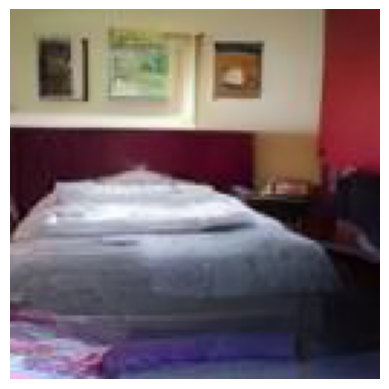

In [448]:
# Example usage
# Assuming you have an input image tensor `input_image` of shape (batch_size, 3, IMG_SIZE, IMG_SIZE)
input_image = sample_image_generation(
    model,
    noise_scheduler,
    1,
    RANDOM_SEED,
    NUM_TIMESTEPS,
    device,
    accelerator,
)  # Replace with your actual image tensor


In [468]:
def get_latent_representation(model, image, timestep):
    model.eval()
    with torch.no_grad():
        down_block_outs = []
        x = model.conv_in(image)
        t_emb = model.time_proj(timestep)
        t_emb = model.time_embedding(t_emb)
        
        for block in model.down_blocks:
            x, _ = block(x, t_emb)
            down_block_outs.append(x)
            print(f"Down block output shape: {x.shape}")
            
        # Pass through mid block
        x = model.mid_block(x, t_emb)
        print(f"Mid block output shape: {x.shape}")
        
        latent_rep = x
    return latent_rep, down_block_outs, t_emb

# Custom forward pass to reconstruct the image from latent representation
# Custom forward pass to reconstruct the image from latent representation
def reconstruct_image_from_latent(model, latent_rep, down_block_outs, t_emb):
    model.eval()
    with torch.no_grad():
        x = latent_rep
        for i, block in enumerate(model.up_blocks):
            if i < len(down_block_outs):
                res_hidden_states = down_block_outs[-(i + 1)]

                print(f"Res hidden states shape before block {i}: {res_hidden_states.shape}")
                print(f"Up block {i} input shape: {x.shape}")
                # Adjust res_hidden_states to match x's shape if needed

                # make sure the res_hidden_states has the same spatial shape as x
               
                res_hidden_states = F.interpolate(
                    res_hidden_states, size=x.shape[-2:], mode="bilinear", align_corners=False
                )
               
                x = block(x, res_hidden_states, t_emb)
            else:
                x = block(x, None, t_emb)
            print(f"Up block {i} output shape: {x.shape}")
        x = model.conv_norm_out(x)
        x = model.conv_act(x)
        reconstructed_image = model.conv_out(x)
        print(f"Final output shape: {reconstructed_image.shape}")
    return reconstructed_image

In [450]:
# Define a timestep, e.g., 0 for simplicity
timestep = torch.tensor([NUM_TIMESTEPS]).to(device)

# Get latent representation
latent_rep = get_latent_representation(model, input_image, timestep)

# Reconstruct image from latent representation
latent_rep, down_block_outs, t_emb = get_latent_representation(model, input_image, timestep)


Down block output shape: torch.Size([1, 128, 48, 48])
Down block output shape: torch.Size([1, 128, 24, 24])
Down block output shape: torch.Size([1, 256, 12, 12])
Down block output shape: torch.Size([1, 256, 6, 6])
Down block output shape: torch.Size([1, 512, 3, 3])
Down block output shape: torch.Size([1, 512, 3, 3])
Mid block output shape: torch.Size([1, 512, 3, 3])
Down block output shape: torch.Size([1, 128, 48, 48])
Down block output shape: torch.Size([1, 128, 24, 24])
Down block output shape: torch.Size([1, 256, 12, 12])
Down block output shape: torch.Size([1, 256, 6, 6])
Down block output shape: torch.Size([1, 512, 3, 3])
Down block output shape: torch.Size([1, 512, 3, 3])
Mid block output shape: torch.Size([1, 512, 3, 3])


In [455]:
latent_rep.shape

torch.Size([1, 512, 3, 3])

In [469]:
reconstructed_image = reconstruct_image_from_latent(model, latent_rep, down_block_outs, t_emb)


Res hidden states shape before block 0: torch.Size([1, 512, 3, 3])
Up block 0 input shape: torch.Size([1, 512, 3, 3])


RuntimeError: Tensors must have same number of dimensions: got 4 and 3

In [ ]:
# Define the inverse transformation
def inverse_preprocess(image):
    # Denormalize the image
    image = (image + 1) / 2
    # Convert the image to the range [0, 1]
    image = torch.clamp(image, 0, 1)
    return image

In [ ]:
reconstructed_image_ = inverse_preprocess(reconstructed_image)

In [ ]:
reconstructed_image_np = reconstructed_image_.cpu().numpy()

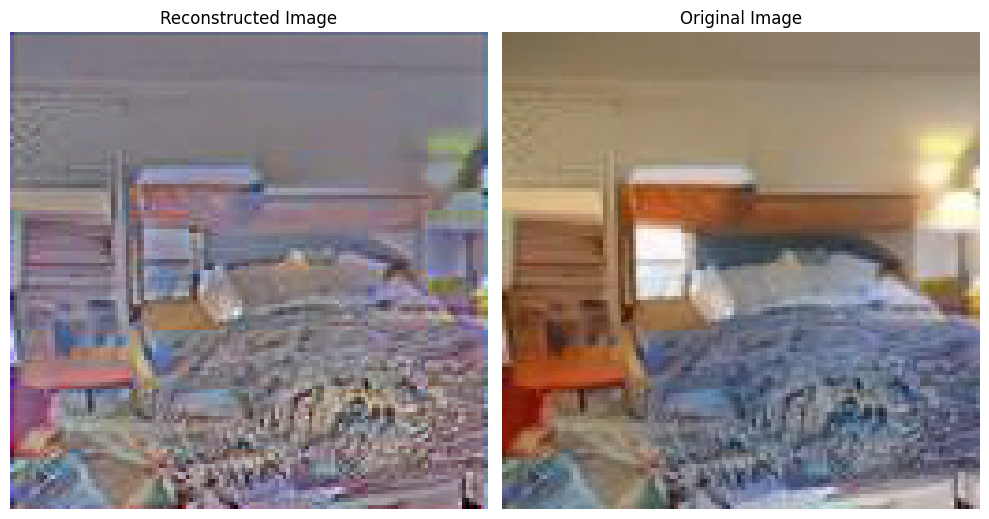

In [ ]:
# plot the reconstructed image and the original image
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(reconstructed_image_np[0].transpose(1, 2, 0))
axes[0].axis("off")
axes[0].set_title("Reconstructed Image")
axes[1].imshow(input_image[0].cpu().numpy().transpose(1, 2, 0))
axes[1].axis("off")
axes[1].set_title("Original Image")
plt.tight_layout()
plt.show()
